# Import packages

# TODO:
- Prioritized memory sweeping
- Double DQN
- Dueling double DQN

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np #install version 1.26.4
import random
import gym #install version 0.25.2
import matplotlib.pyplot as plt
from collections import namedtuple, deque

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Experience replay buffer

- First, each step of experience is potentially used in many weight updates, which allows for greater data efficiency.
- Second, learning directly from consecutive samples is inefficient, owing to the strong correlations between the samples; randomizing the samples breaks these correla- tions and therefore reduces the variance of the updates.
- Third, when learning on- policy the current parameters determine the next data sample that the parameters are trained on. For example, if the maximizing action is to move left then the train- ing samples will be dominated by samples from the left-hand side; if the maximiz- ing action then switches to the right then the training distribution will also switch. It is easy to see how unwanted feedback loops may arise and the parameters could get stuck in a poor local minimum, or even diverge catastrophically.

By using experience replay the behaviour distribution is averaged over many of its previous states, smoothing out learning and avoiding oscillations or divergence in the parameters. Note that when learning by experience replay, it is necessary to learn off-policy (because our current parameters are different to those used to generate the sam- ple), which motivates the choice of Q-learning.





In [2]:
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

# Define the Q network for DRL

In [3]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 192)
        self.fc2 = nn.Linear(192, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)


# Define RL Agent

## ϵ - greedy policy
- Always sampling from memory is not a wise choice, as the agent will not explore other potential actions and can reach a sub optimal solution. For this reason using ϵ-greedy algorithm helps in avoiding such problem. In this, experiences are chosen with 1-ϵ probability and ranomdly with probability ϵ.

- Begin with a higher ϵ value and then gradually decrease the epsilon to minimum value to provide the balance between exploration and efficiency.

## soft updates to target network
- An other modification to online Q-learning aimed at further improving the stability of our method with neural networks is to use a separate network for gen- erating the targets yj in the Q-learning update. More precisely, every C updates we clone the network Q to obtain a target network Q^ and use Q^ for generating the Q-learning targets yj for the following C updates to Q. This modification makes the algorithm more stable compared to standard online Q-learning, where an update that increases Q(st,at) often also increases Q(st 1 1,a) for all a and hence also increases the target yj, possibly leading to oscillations or divergence of the policy. Generating the targets using an older set of parameters adds a delay between the time an update to Q is made and the time the update affects the targets yj, making divergence or oscillations much more unlikely.

In [4]:
class DQNAgent():
    def __init__(self, state_size, action_size, seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=5e-4)

        # Replay memory
        self.memory = ReplayBuffer(int(1e5), 64)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % 4
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > 64:
                experiences = self.memory.sample()
                self.learn(experiences, 0.99)

    def act(self, state, eps=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, 1e-3)

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


Sure, I'd be happy to explain that line of code.

The line of code you provided is used to compute the maximum Q-value for each next state in a batch of experiences. Here's a breakdown of what each part of the code does:

* `self.qnetwork_target(next_states)`: This part of the code passes the batch of next states through the target Q-network to compute the Q-values for each action in each next state. The output is a tensor of shape `(batch_size, action_size)`.
* `.detach()`: This method is used to detach the output tensor from the computation graph. This is done to prevent gradients from flowing back through the target Q-network during the optimization step.
* `.max(1)[0]`: This part of the code computes the maximum Q-value for each next state in the batch. The `max` function returns a tuple of the maximum values and their indices, but we only care about the maximum values, so we take the first element of the tuple using `[0]`. The output is a tensor of shape `(batch_size,)`.
* `.unsqueeze(1)`: This method is used to add a new dimension to the tensor at the specified position. In this case, we use `unsqueeze(1)` to add a new dimension to the tensor at position 1, which changes the shape of the tensor from `(batch_size,)` to `(batch_size, 1)`. This is done to make the tensor compatible with the shape of the other tensors in the computation graph.

Overall, the line of code computes the maximum Q-value for each next state in the batch of experiences, detaches the output tensor from the computation graph to prevent gradients from flowing back through the target Q-network, and reshapes the tensor to have the same shape as the other tensors in the computation graph. This tensor is then used to compute the target Q-values for the current states in the batch of experiences.

# Training

In [5]:
def train_dqn(agent, env, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

# Initialize the environment and the agent
env_name = "CartPole-v1" #
env = gym.make(env_name)
agent = DQNAgent(state_size=env.env.observation_space.shape[0], action_size=env.action_space.n, seed=0)

# Train the agent
scores = train_dqn(agent, env)


/home/naresh/anaconda3/envs/aiml_torch/lib/python3.12/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/naresh/anaconda3/envs/aiml_torch/lib/python3.12/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/naresh/anaconda3/envs/aiml_torch/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 100	Average Score: 18.53
Episode 200	Average Score: 14.28
Episode 300	Average Score: 12.67
Episode 400	Average Score: 13.98
Episode 500	Average Score: 19.46
Episode 600	Average Score: 147.54
Episode 612	Average Score: 202.46
Environment solved in 512 episodes!	Average Score: 202.46


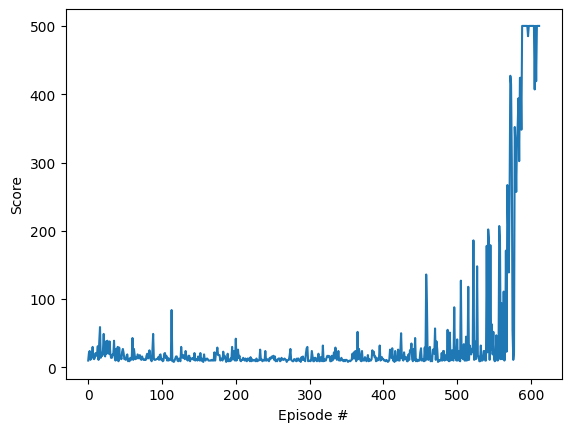

In [6]:
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [7]:
def test_agent(agent, env, n_episodes=10):
    """Test the trained agent.

    Params
    ======
        n_episodes (int): number of episodes to test the agent
    """
    scores = []
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        while True:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            state = next_state
            score += reward
            if done:
                break
        scores.append(score)
        print('\rEpisode {}\tScore: {:.2f}'.format(i_episode, score))
    print('\nAverage Score: {:.2f}'.format(np.mean(scores)))

# Initialize the environment and the agent
env = gym.make('CartPole-v1')
agent = DQNAgent(state_size=4, action_size=2, seed=0)

# Load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

# Test the agent
test_agent(agent, env)

Episode 1	Score: 500.00
Episode 2	Score: 500.00
Episode 3	Score: 500.00
Episode 4	Score: 500.00


/home/naresh/anaconda3/envs/aiml_torch/lib/python3.12/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/naresh/anaconda3/envs/aiml_torch/lib/python3.12/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/tmp/ipykernel_136917/1002696532.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECU

Episode 5	Score: 500.00
Episode 6	Score: 500.00
Episode 7	Score: 500.00
Episode 8	Score: 500.00
Episode 9	Score: 500.00
Episode 10	Score: 500.00

Average Score: 500.00
